[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EF20K/Projects/blob/main/Getting_Started_w_Dataset.ipynb)
# Exploratory Data Analysis of the House Oversight Committee Epstein Files

## 🚀 Introduction

### Target Audience

This tutorial is designed for **accessibility**, allowing researchers, investigative journalists, legal professionals, and data analysts to easily follow and execute the steps necessary for data ingestion and comprehensive summary.

## 📋 Phase I: Initial Data Ingestion and Summarization

The analysis begins with two critical foundational steps to prepare the text corpus for deep-dive analysis.

### 1. Dataset Download and Ingestion
We will start by downloading the dataset from the source and loading the document structure into a pandas DataFrame.

### 2. High-Level Summary
Following ingestion, we will immediately summarize the loaded data. This step will provide a crucial overview of the corpus characteristics, including the total number of documents and general statistics on the **`text`** content, setting the stage for subsequent analytical phases.

In [2]:
from datasets import load_dataset

#We load the dataset into a varaible called ds
ds = load_dataset("tensonaut/EPSTEIN_FILES_20K")

#We then convert our dataset into a columnar format so we can do analysis
df= ds['train'].to_pandas()
display(df)

,filename,text
0,IMAGES-005-HOUSE_OVERSIGHT_020367.txt,215\n\nThe final choice he was made to board a...
1,IMAGES-001-HOUSE_OVERSIGHT_011104.txt,What matters is return. I don’t have to specif...
2,TEXT-001-HOUSE_OVERSIGHT_031683.txt,From: J [jeevacation@gmail.com] \nSent: 5/30/2...
3,IMAGES-005-HOUSE_OVERSIGHT_018820.txt,"Area Analysis 10\n\nAt the national level, the..."
4,IMAGES-009-HOUSE_OVERSIGHT_027193.txt,Time: 03/01/17 04:45:15 AM (510065115)\n\nFlag...
...,...,...
25795,IMAGES-002-HOUSE_OVERSIGHT_012874.txt,experiments were related in one way or another...
25796,IMAGES-005-HOUSE_OVERSIGHT_018839.txt,Marina Market Analysis 29\n\nThe table that fo...
25797,IMAGES-003-HOUSE_OVERSIGHT_016083.txt,Bibliography 393\n\nMichael Brooks. 13 Things ...
25798,TEXT-002-HOUSE_OVERSIGHT_033235.txt,From: Richard Kahn \nSent: 5/9/2017 9:22:35 PM...


# 📁 Data Structure and Source Overview for Text Analysis

This section provides an overview of the data structure and explains how the text data is linked back to its original source files from the **House Committee Google Drive** documents.

***

## 📊 DataFrame Structure

The extracted text has been loaded into a DataFrame, which currently contains two key columns:

1.  **`filename`**: A unique string combining the original source folder names and the file name, used to link the text back to its source.
2.  **`text`**: The extracted textual content from the corresponding source file.


In [ ]:

# Here we extract the main folder information from the filename so we can get a better summary
df['MAIN_FOLDER'] = df['filename'].map(lambda x: x.split("-")[0])

display(df.describe())

,filename,text,MAIN_FOLDER
count,25800,25793,25800
unique,25800,25784,2
top,TEXT-001-HOUSE_OVERSIGHT_030584.txt,﻿,IMAGES
freq,1,2,22903


# 🧹 Phase II: Data Quality Assessment and Pre-Processing

Following the initial data ingestion, a good assessment of data quality is required to ensure the reliability of downstream analysis. This phase addresses observed inconsistencies in the DataFrame.

## ⚠️ Data Quality Findings

Analysis of the DataFrame has identified two primary data quality issues requiring immediate remediation:

| Metric | Value | Implication |
| :--- | :--- | :--- |
| **Total Entries** | 25,793 | Total rows in the DataFrame. |
| **Unique Text Entries** | 25,784 | Indicates the presence of **9 duplicate rows** in the dataset. |
| **Missing Values** | The most frequent value in the `text` column is an **empty string (`''`)**. | Suggests files where text extraction failed, or the source document contained no legible text. |

## 📁 Contextualizing Folder Discrepancies

While the official Google Drive repository contains four top level folders, the current text DataFrame only reflects content extracted from two of them.

**Reason for Exclusion:**
The folders not appearing in the current DataFrame—**`DATA`** and **`NATIVE`**—primarily contain non-textual or structural files such as Excel sheets, raw metadata, and other binary media. These files do not yield meaningful output for linguistic analysis and were therefore excluded

## ✨ Next Step: Data Cleanup

The presence of duplicate rows and entries with missing text necessitates a focused cleanup process to prepare the corpus for analysis. The next steps will involve:
1.  **Duplicate Removal:** Eliminating the redundant rows
2.  **Missing Data Handling:** Removing entries where the `text` column is empty

In [3]:
def clean_dataframe(df):

    # Remove any rows with empty or missing values
    df = df.dropna()

    # Drop duplicate rows based on the 'text' column
    df = df.drop_duplicates(subset=['text'], keep='first')

    # Add a new column with text lengths
    df['text_len'] = df['text'].map(lambda x: len(x))

    # Keep only rows where text length is greater than 50 characters
    df = df[df['text_len'] > 50]

    del df['text_len']

    # Clean text: remove BOM, collapse whitespace, strip ends
    df["text"] = (
        df["text"]
        .str.replace("\ufeff", "", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    return df

df = clean_dataframe(df)

In [4]:
# Now, that you have everything cleaned up, you can summarize again
display(df.describe())

,filename,text
count,25312,25312
unique,25312,25312
top,IMAGES-001-HOUSE_OVERSIGHT_011109.txt,"confidence, we would know how much correction ..."
freq,1,1


Source File Type and OCR Noise Assessment

Before proceeding with advanced analysis, it is critical to understand the distribution of the source file types, as this directly impacts the quality and reliability of the extracted text.

## 📊 Source Type Breakdown

A review of the **`filename`** prefix

| Source Folder | File Count | Percentage | Implication |
| :--- | :--- | :--- | :--- |
| **`IMAGES`** | 22,427 | $\approx 88.6\%$ | Text derived from Optical Character Recognition (OCR) |
| **`text`**  | 2,885 | $\approx 11.4\%$ | Text derived from native digital documents (e.g., PDFs, Word) |
| **Total Clean Entries** | 25,312 | $100\%$ | (After initial cleanup) |

**Key Finding:**
Approximately **88%** of the documents in our current corpus originate from images that required processing via Optical Character Recognition (OCR). This is a crucial distinction, as OCR-derived text is inherently prone to **noise, typographical errors, and misspellings**, which must be accounted for in all subsequent NLP tasks.

## 🔎 Transition to Exploratory Data Analysis (EDA)

With the data quality issues addressed and source context established, we can now commence the actual exploratory analysis phase.

A fundamental step in reviewing a corpus of this nature is to determine the key **entities** and individuals mentioned within the documents.

### 🎯 Next Step: Named Entity Recognition (NER)

This following code block initializes a **Named Entity Recognition (NER)** pipeline using the high-performance **Hugging Face Transformers** library and the **`dslim/bert-large-NER`** model.

Its purpose is to efficiently extract key entities (People, Organizations, Locations) from every document in the `text` column. The results are stored in a new column called **`entities`** for subsequent analysis.

### ⚠️ Execution Time Warning

**Please note:** This process utilizes the GPU and will take approximately **20 minutes** to run on the full dataset. You need to ensure you go to your top right corner, click on the down arrow next to RAM/DISK and change runtime to L4

In [ ]:
# The following code takes around 20 minutes to run on the free L4 gpu available on collab. If i
import json
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

MODEL_ID = "dslim/bert-large-NER"

# Build NER pipeline once
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForTokenClassification.from_pretrained(MODEL_ID)

ner_pipe = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # merge B-/I- into full spans
    device=0,                      # set to 0 if you have GPU enabled
)

def add_hf_ner(df, text_col="text", out_col="entities", batch_size=32):
    """
    Runs HF NER over df[text_col] and stores a JSON list per row in out_col.
    Each entry looks like:
      [{"text": "...", "label": "PER"}, {"text": "...", "label": "ORG"}, ...]
    """
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        batch_outputs = ner_pipe(batch)

        for ents in batch_outputs:
            spans = [
                {
                    "text": ent["word"],
                    "label": ent["entity_group"],  # PER / ORG / LOC / MISC
                }
                for ent in ents
            ]
            # store as JSON string for CSV / HF
            all_entities.append(json.dumps(spans, ensure_ascii=False))

    df[out_col] = all_entities
    return df

# --- Run on your df ---
ndf = add_hf_ner(df, text_col="text", out_col="entities")

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


  0%|          | 0/791 [00:00<?, ?it/s]

In [ ]:
# You can print the output and see the NER outputed. It would be under the "entities column"
print(ndf)

                                    filename  \
0      IMAGES-005-HOUSE_OVERSIGHT_020367.txt   
1      IMAGES-001-HOUSE_OVERSIGHT_011104.txt   
2        TEXT-001-HOUSE_OVERSIGHT_031683.txt   
3      IMAGES-005-HOUSE_OVERSIGHT_018820.txt   
4      IMAGES-009-HOUSE_OVERSIGHT_027193.txt   
...                                      ...   
25795  IMAGES-002-HOUSE_OVERSIGHT_012874.txt   
25796  IMAGES-005-HOUSE_OVERSIGHT_018839.txt   
25797  IMAGES-003-HOUSE_OVERSIGHT_016083.txt   
25798    TEXT-002-HOUSE_OVERSIGHT_033235.txt   
25799    TEXT-001-HOUSE_OVERSIGHT_030584.txt   

                                                    text MAIN_FOLDER  \
0      215 The final choice he was made to board a no...      IMAGES   
1      What matters is return. I don’t have to specif...      IMAGES   
2      From: J [jeevacation@gmail.com] Sent: 5/30/201...        TEXT   
3      Area Analysis 10 At the national level, the U....      IMAGES   
4      Time: 03/01/17 04:45:15 AM (510065115) Flags: ...      I

## 📊 Entity Analysis and Visualization

With the NER results now embedded in the DataFrame, the next steps focus on extracting and visualizing the most prominent entities. (The following might be too technical to some users, you can just skip and go ahead and run the code blocks)

### 1. Data Transformation: Flattening Entities

The first code block is crucial for transforming the structured JSON data in the new `entities` column into a flat, analysis-ready DataFrame (`ents`). By expanding each JSON list into its own row, we create a table that allows us to efficiently count every single occurrence of every extracted entity across the entire corpus. This resulting table will have columns for the entity's text, its label (e.g., PER, ORG), and its length.

### 2. Visualization: Identifying Key Entities

The second block defines and executes a plotting function to visualize the results. It filters the flattened data by entity type (PER, ORG, LOC, MISC) and generates four distinct horizontal bar charts. These charts immediately highlight the **Top 20** most frequently mentioned people, organizations, locations, and miscellaneous entities, providing the first major insights into the corpus content.

In [ ]:
import pandas as pd
def build_entities_table(df, entities_col="entities"):
    """
    Flatten the JSON entities column into a long DataFrame:
    columns: row_id, text, label, lent
    """
    rows = []
    for idx, ents_json in df[entities_col].items():
        ents_list = json.loads(ents_json)
        for ent in ents_list:
            rows.append(
                {
                    "row_id": idx,
                    "text": ent["text"],
                    "label": ent["label"],
                    "len":len(ent["text"])
                }
            )
    return pd.DataFrame(rows)


ents = build_entities_table(ndf)

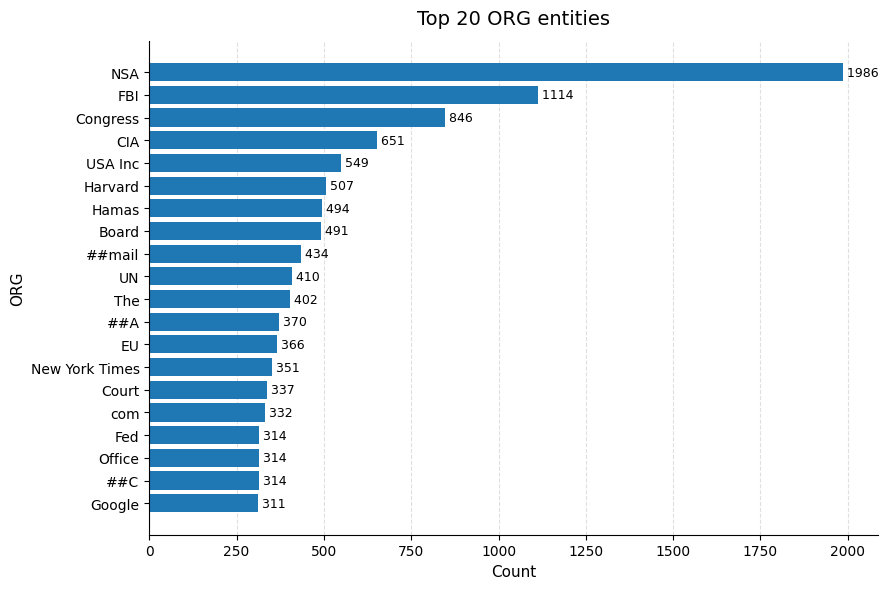

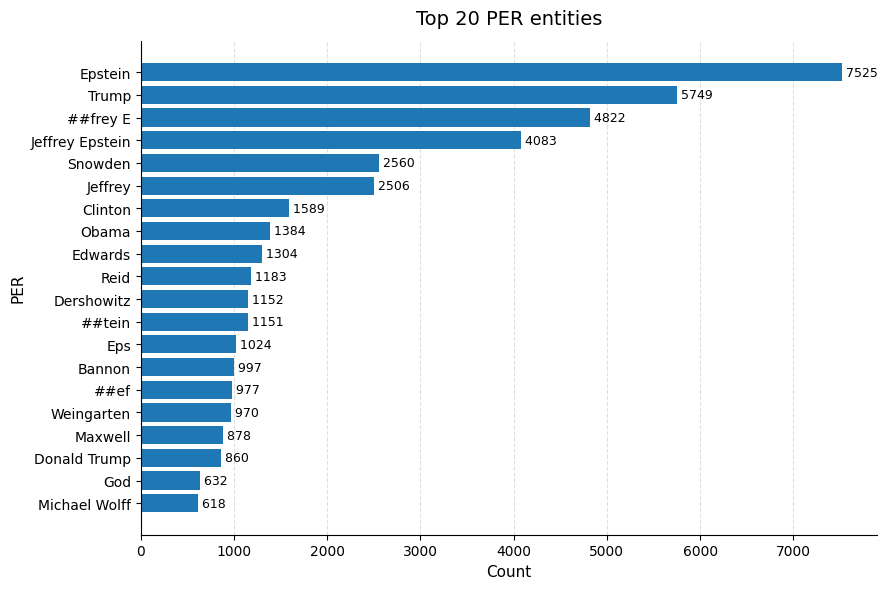

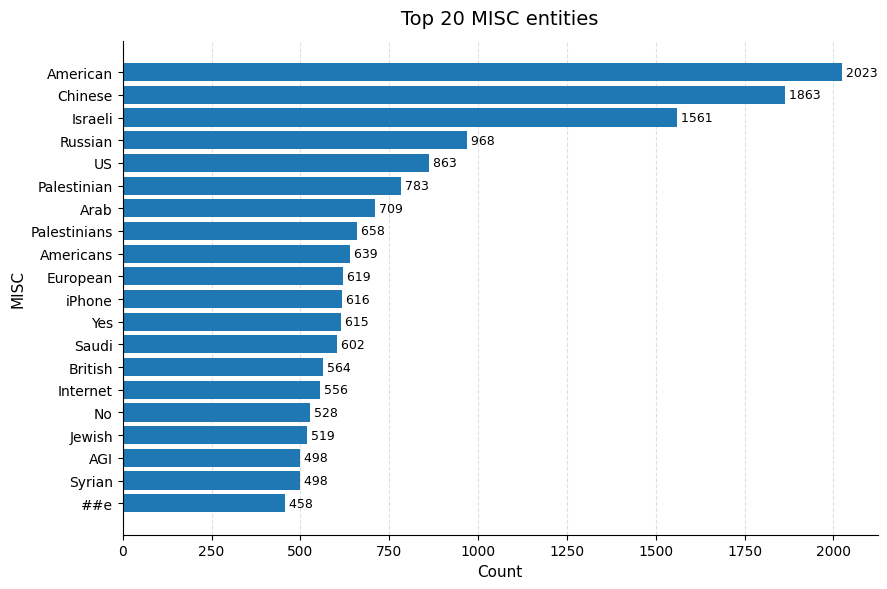

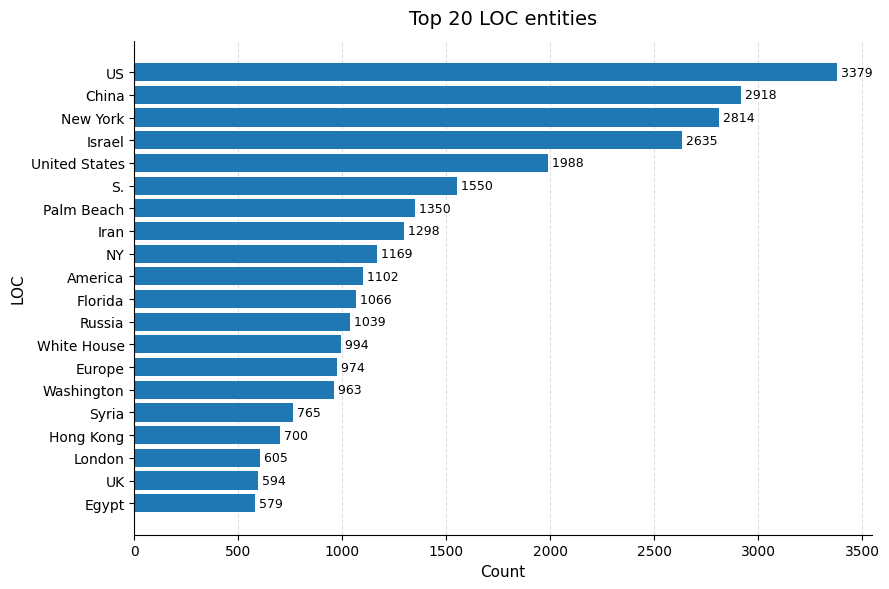

In [ ]:
import matplotlib.pyplot as plt

def plot_top_entities(ents_df, label, top_n=20, min_len=2):
    # Filter + count
    counts = (
        ents_df[(ents_df["label"] == label) & (ents_df["len"] >= min_len)]["text"]
        .value_counts()
        .head(top_n)
        .sort_values()  # sort so smallest at bottom, largest at top in barh
    )

    fig, ax = plt.subplots(figsize=(9, 6))

    # Horizontal bar plot
    ax.barh(counts.index.astype(str), counts.values)

    # Title & labels
    ax.set_xlabel("Count", fontsize=11)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f"Top {top_n} {label} entities", fontsize=14, pad=12)

    # Light grid only on x-axis
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    ax.set_axisbelow(True)

    # Remove top/right spines for a cleaner look
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Add value labels at the end of each bar
    for i, v in enumerate(counts.values):
        ax.text(
            v,                      # x (end of bar)
            i,                      # y (bar index)
            f" {v}",                # text
            va="center",
            ha="left",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

plot_top_entities(ents, "ORG", top_n=20)
plot_top_entities(ents, "PER", top_n=20)
plot_top_entities(ents, "MISC", top_n=20)
plot_top_entities(ents, "LOC", top_n=20)

## 📧 Rule-Based Email Identification

Next, instead of relying on a complex AI classifier, we will use a **rule-based approach** involving **Regular Expressions (Regex)** to quickly and accurately identify documents that are likely to be email messages.

This code block filters the dataset by checking for common email indicators, such as:
1.  **Headers** (`From:`, `To:`, `Subject:`).
2.  **Reply patterns** (`>`).
3.  **Email addresses** (`user@domain.com`).

The results will be stored in two new boolean columns: `is_email_message` and `has_email_address`. This allows us to cleanly isolate the email conversations for focused analysis and plotting.

In [ ]:
# We don't need a fancy AI classifer, we can simply have a rule based classifer

import re
import time
from tqdm import tqdm

# Patterns for email HEADERS (detecting email messages)
HEADER_PATTERNS = [
    re.compile(r'^\s*From:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*To:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*Subject:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*Sent:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*Date:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*Cc:\s*.+', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*Bcc:\s*.+', re.IGNORECASE | re.MULTILINE),
]

# Patterns for reply/forward indicators
REPLY_PATTERNS = [
    re.compile(r'On\s.{0,200}(wrote|sent):\s*$', re.IGNORECASE | re.MULTILINE),
    re.compile(r'^\s*>', re.MULTILINE),
]

# Pattern for EMAIL ADDRESSES (user@domain.com)
EMAIL_ADDRESS_PATTERN = re.compile(
    r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
)

def contains_email_content(text_block):
    """
    Detect if text contains email MESSAGE structure (headers, replies, etc.)
    """
    if not isinstance(text_block, str):
        return False

    text_sample = text_block[:]

    # Check for reply patterns
    for pattern in REPLY_PATTERNS:
        if pattern.search(text_sample):
            return True

    # Check for email headers (need at least 2)
    for pattern in HEADER_PATTERNS:
        if pattern.search(text_sample):
            return True

    return False

def contains_email_address(text_block):
    if not isinstance(text_block, str):
        return False

    # Check first 10000 chars (email addresses usually appear early)
    text_sample = text_block[:10000]

    return bool(EMAIL_ADDRESS_PATTERN.search(text_sample))


if __name__ == "__main__":
    print(f"Processing {len(ndf)} documents...")
    start = time.time()

    # Detect email MESSAGE structure
    try:
        ndf["is_email_message"] = [
            contains_email_content(text)
            for text in tqdm(ndf["text"], desc="Detecting email messages")
        ]
    except NameError:
        ndf["is_email_message"] = [
            contains_email_content(text) for text in ndf["text"]
        ]

    # Detect email ADDRESSES
    try:
        ndf["has_email_address"] = [
            contains_email_address(text)
            for text in tqdm(ndf["text"], desc="Detecting email addresses")
        ]
    except NameError:
        ndf["has_email_address"] = [
            contains_email_address(text) for text in ndf["text"]
        ]

    elapsed = time.time() - start

    # Results
    email_msg_count = ndf["is_email_message"].sum()
    email_addr_count = ndf["has_email_address"].sum()

    print(f"\n{'='*60}")
    print(f"✓ Completed in {elapsed:.2f} seconds")
    print(f"✓ Email MESSAGES found: {email_msg_count:,} ({email_msg_count/len(ndf)*100:.1f}%)")
    print(f"✓ Email ADDRESSES found: {email_addr_count:,} ({email_addr_count/len(ndf)*100:.1f}%)")
    print(f"✓ Processing speed: {len(ndf)/elapsed:.0f} docs/second")
    print(f"{'='*60}\n")

    # Show breakdown
    print("Breakdown:")
    print(f"  • Has email message BUT no address: {((ndf['is_email_message']) & (~ndf['has_email_address'])).sum()}")
    print(f"  • Has email address BUT no message: {((~ndf['is_email_message']) & (ndf['has_email_address'])).sum()}")
    print(f"  • Has BOTH message and address: {((ndf['is_email_message']) & (ndf['has_email_address'])).sum()}")
    print(f"  • Has NEITHER: {((~ndf['is_email_message']) & (~ndf['has_email_address'])).sum()}")


Processing 25312 documents...


Detecting email addresses: 100%|██████████| 25312/25312 [00:01<00:00, 18026.58it/s]


✓ Completed in 12.01 seconds
✓ Email MESSAGES found: 4,857 (19.2%)
✓ Email ADDRESSES found: 7,792 (30.8%)
✓ Processing speed: 2108 docs/second

Breakdown:
  • Has email message BUT no address: 307
  • Has email address BUT no message: 3242
  • Has BOTH message and address: 4550
  • Has NEITHER: 17213


In [ ]:
# We keep cases where we see both cases are true

print(ndf[(ndf['is_email_message']==True) & (ndf['has_email_address']==True)])



                                  filename  \
2      TEXT-001-HOUSE_OVERSIGHT_031683.txt   
12     TEXT-001-HOUSE_OVERSIGHT_022827.txt   
14     TEXT-001-HOUSE_OVERSIGHT_025190.txt   
19     TEXT-002-HOUSE_OVERSIGHT_032654.txt   
21     TEXT-001-HOUSE_OVERSIGHT_029972.txt   
...                                    ...   
25746  TEXT-002-HOUSE_OVERSIGHT_032671.txt   
25753  TEXT-002-HOUSE_OVERSIGHT_033209.txt   
25776  TEXT-002-HOUSE_OVERSIGHT_032659.txt   
25798  TEXT-002-HOUSE_OVERSIGHT_033235.txt   
25799  TEXT-001-HOUSE_OVERSIGHT_030584.txt   

                                                    text MAIN_FOLDER  \
2      From: J [jeevacation@gmail.com] Sent: 5/30/201...        TEXT   
12     From: jeffrey E. [jeeyacation@gmail.com] Sent:...        TEXT   
14     From: jeffrey E. [jeeyacation@gmail.com] Sent:...        TEXT   
19     From: Lesley Groff Sent: 11/17/2017 12:17:02 P...        TEXT   
21     From: Lesley Groff Sent: 10/13/2015 6:48:37 PM...        TEXT   
...            

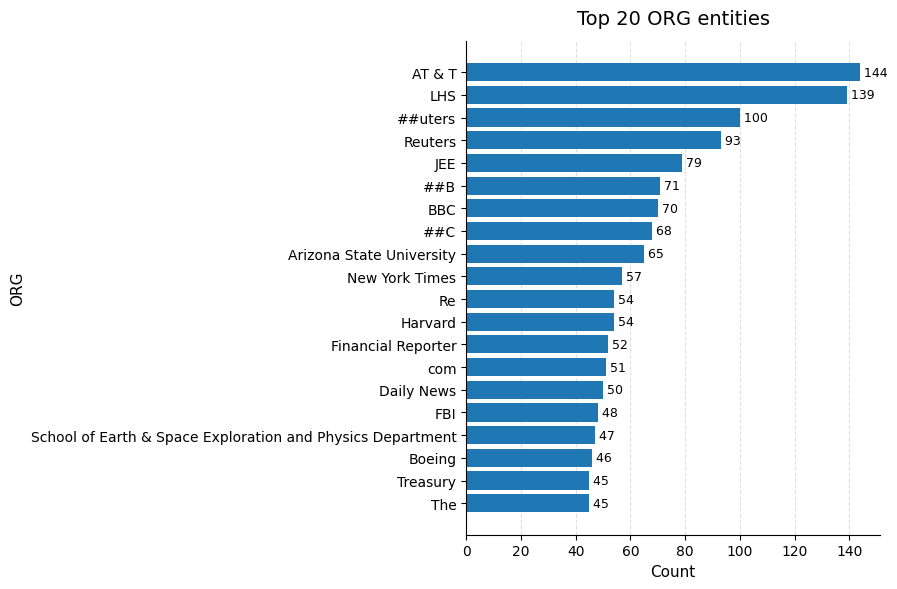

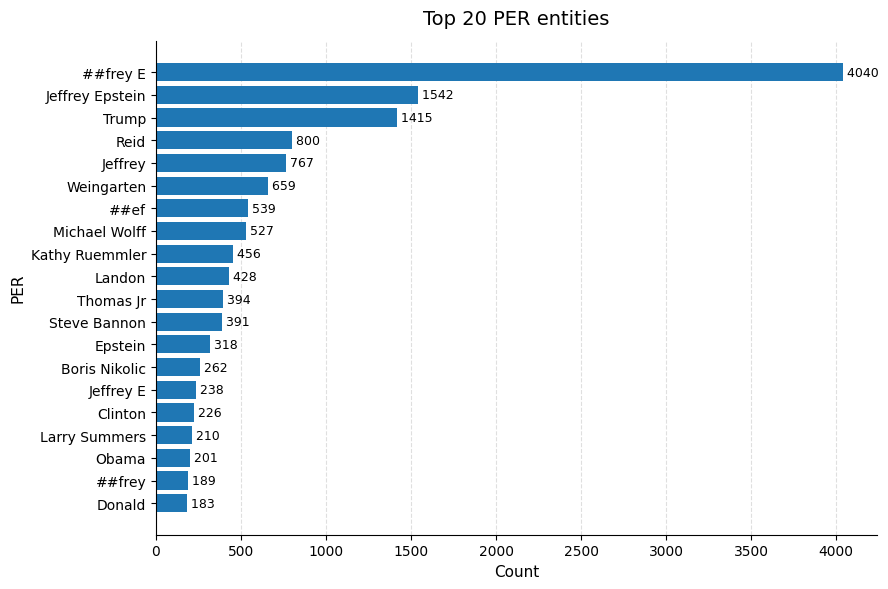

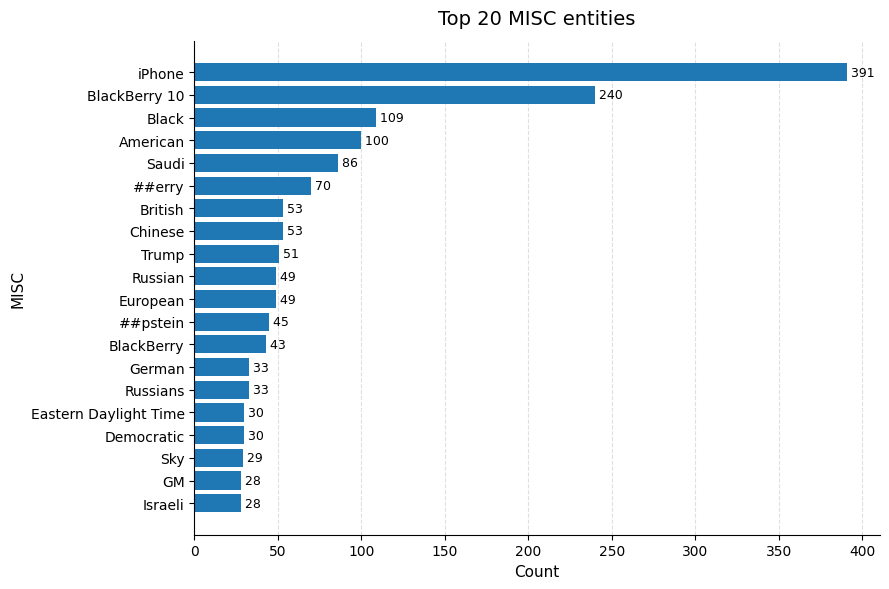

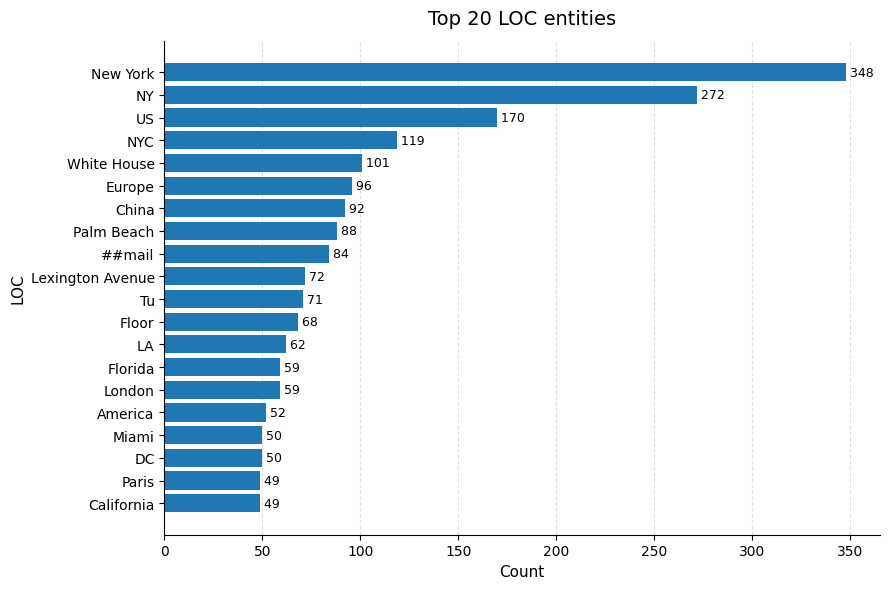

In [ ]:
import matplotlib.pyplot as plt

def plot_top_entities(ents_df, label, top_n=20, min_len=2):

    counts = (
        ents_df[(ents_df["label"] == label) & (ents_df["len"] >= min_len)]["text"]
        .value_counts()
        .head(top_n)
        .sort_values()  # sort so smallest at bottom, largest at top in barh
    )

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.barh(counts.index.astype(str), counts.values)
    ax.set_xlabel("Count", fontsize=11)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f"Top {top_n} {label} entities", fontsize=14, pad=12)
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for i, v in enumerate(counts.values):
        ax.text(
            v,                      # x (end of bar)
            i,                      # y (bar index)
            f" {v}",                # text
            va="center",
            ha="left",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

ndf_emails = ndf[(ndf['is_email_message']==True) & (ndf['has_email_address']==True)]
ents_emails =build_entities_table(ndf_emails)
plot_top_entities(ents_emails, "ORG", top_n=20)
plot_top_entities(ents_emails, "PER", top_n=20)
plot_top_entities(ents_emails, "MISC", top_n=20)
plot_top_entities(ents_emails, "LOC", top_n=20)

## 📊 Output: Focused Entity Visualization from Emails

This code block executes a **focused visual analysis** on the subset of documents confirmed to be emails. It produces **four distinct horizontal bar charts** showing the frequency of the **Top 20** named entities found *only* within the email communications.

### Output Summary

The code generates the following four plots:

1.  **Top 20 `ORG` (Organizations)** mentioned in the emails.
2.  **Top 20 `PER` (People)** mentioned in the emails.
3.  **Top 20 `MISC` (Miscellaneous)** entities mentioned in the emails.
4.  **Top 20 `LOC` (Locations)** mentioned in the emails.

### Chart Characteristics

Each chart is a **horizontal bar graph** where:
* The **Y-axis** lists the specific entity name (e.g., "Jeffrey Epstein").
* The **X-axis** represents the **Count** (frequency of mention).
* Entities are **sorted** from least frequent at the bottom to most frequent at the top, clearly highlighting the most prominent entities within the email data.